In [1]:
#import basic library
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time as t

#import tensorflow
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

#import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

2022-05-24 22:32:13.329196: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
#load CSV files
path = r"./DM_data"
csvs = os.listdir(path)

#Setting features name
col1 = [f"1-{i+1}" for i in range(30)]
col2 = [f"2-{j+1}" for j in range(4)]
col3 = [f"3-{k+1}" for k in range(15)]
col4 = [f"4-{m+1}" for m in range(3)]
lab = [f"label-{l+1}" for l in range(6)]
columns = col1 + col2 + col3 + col4 + lab
X_columns = col1 + col2 + col3 + col4
drop_features = ["SID","SCHID","GENDER"]

"""
features 이름을 헷갈리지 않게 정해줍니다. 데이터의 features는 크게 4가지 카테고리로 나뉘는데,
feature 이름을 "큰 카테고리-feature번호"로 설정했습니다.
그리고 ID를 나타내는 3개의 feature들은 drop시켰습니다.
"""

#load CSV to DataFrame
df = [pd.read_csv(os.path.join(path, csvs[d])) for d in range(2)]

for d in df:
    d.drop(drop_features, axis=1, inplace=True)
    d.columns = columns

#concatenate df 1,2
total_df = pd.concat([df[0], df[1]])
missing = total_df[total_df["1-1"]==-1].index
total_df.drop(missing, inplace=True)

"""
features가 다른 3학년을 제외한 1,2학년 데이터를 합쳤습니다.
그리고 missing data를 날려버렸습니다.
"""

#Make Minmax scaler
scaler = MinMaxScaler()

total_df = pd.DataFrame(scaler.fit_transform(total_df), columns=columns)
X_data = total_df.loc[:, :"4-3"]
Y_data = total_df.loc[:,"label-1":"label-3"]

total_score = Y_data.sum(axis=1) * 100 / 3
Y_data = pd.DataFrame(np.array(total_score).reshape(-1, 1), columns=["average score"])

"""
데이터를 minmax scaler로 normalization하고, 국어, 영어, 수학 3개로 되어있는 라벨을
국영수 평균 1개로 만들었습니다. 저희가 알고싶은 것은 국어, 영어, 수학 개별 성적이 아닌
전체 평균성적입니다.
"""

display(X_data)
display(Y_data)

#train test data split | train : test = 0.8 : 0.2
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=26) 

,1-1,1-2,1-3,1-4,1-5,1-6,1-7,1-8,1-9,1-10,...,3-9,3-10,3-11,3-12,3-13,3-14,3-15,4-1,4-2,4-3
0,1.00,0.833333,0.833333,0.833333,0.833333,0.666667,0.833333,0.666667,0.833333,0.833333,...,0.6,0.8,0.8,0.8,0.8,0.6,0.4,0.833333,0.666667,0.833333
1,0.75,0.833333,0.833333,0.833333,0.833333,0.666667,0.666667,0.666667,0.833333,0.833333,...,0.8,0.8,0.8,0.6,0.8,0.8,0.8,1.000000,1.000000,1.000000
2,0.75,0.666667,0.666667,0.666667,0.833333,0.833333,0.833333,0.666667,0.833333,1.000000,...,0.8,0.8,0.8,0.8,0.8,0.8,0.8,1.000000,1.000000,1.000000
3,1.00,0.833333,0.833333,0.833333,0.666667,0.833333,0.666667,0.500000,0.833333,0.833333,...,0.6,0.6,0.8,0.8,0.8,0.8,1.0,0.833333,0.833333,0.833333
4,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.4,0.4,1.0,0.6,0.8,1.0,1.0,1.000000,1.000000,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12837,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667,0.833333,...,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.666667,0.500000,0.500000
12838,1.00,0.833333,0.666667,0.833333,0.833333,0.666667,0.833333,0.666667,1.000000,1.000000,...,0.8,0.8,0.8,0.8,0.8,0.6,0.6,1.000000,0.833333,0.833333
12839,0.75,0.833333,0.666667,0.666667,0.666667,0.833333,0.666667,0.833333,1.000000,1.000000,...,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.833333,1.000000,1.000000
12840,1.00,0.833333,0.833333,1.000000,0.833333,0.500000,0.666667,0.500000,0.833333,1.000000,...,1.0,1.0,0.8,0.8,1.0,0.8,0.8,0.666667,1.000000,0.833333


,average score
0,49.174917
1,82.838284
2,84.488449
3,60.726073
4,66.996700
...,...
12837,36.633663
12838,81.188119
12839,60.066007
12840,59.405941


In [3]:
#Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_hat = lr.predict(X_train)
y_test_hat = lr.predict(X_test)

print(f"LR train RMSE : {MSE(y_train, y_train_hat) ** 0.5}")
print(f"LR test RMSE : {MSE(y_test, y_test_hat) ** 0.5}")

"""
label이 continuous하기 때문에 제일 기초적인 linear regression모델을 써봤습니다.
RMSE값이 가장 직관적(단위가 같음)이기 때문에 이후 나오는 모든 loss는 RMSE를 썼습니다.
train loss와 test loss가 거의 같기 때문에 overfitting되지 않고 잘 나왔습니다.
"""

LR train RMSE : 15.79466627842823
LR test RMSE : 16.120879011856715


'\nlabel이 continuous하기 때문에 제일 기초적인 linear regression모델을 써봤습니다.\nRMSE값이 가장 직관적(단위가 같음)이기 때문에 이후 나오는 모든 loss는 RMSE를 썼습니다.\ntrain loss와 test loss가 거의 같기 때문에 overfitting되지 않고 잘 나왔습니다.\n'

In [4]:
#DNN
def create_model(input_size):
    modelf = Sequential()
    modelf.add(Dense(64, input_shape = [input_size], activation='relu'))
    modelf.add(Dense(32, activation='relu'))
    modelf.add(Dense(32, activation='relu'))
    modelf.add(Dense(16, activation='relu'))
    modelf.add(Dense(1))

    #modelf.summary()
    modelf.compile(optimizer=Adam(learning_rate=0.1),
                  loss='mse',
                  metrics=['mse'])
    return modelf

model = create_model(52)
history = model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=False)
pre = model.predict(X_test)
print(f"RMSE : {MSE(pre, y_test)**0.5}")

"""
다른 종류의 머신러닝 알고리즘보다 DNN의 성능이 좋을 것으로 예상해 학습을 시켰습니다.
하지만 다른 알고리즘과 거의 비슷한 결과가 나온 것을 볼 수 있습니다.

hidden layer는 3층, activation은 ReLU를 썼고, optimizer는 Adam을 썼습니다.
input layer의 node 수는 당연히 feature개수입니다.
layer의 수를 늘려도보고, BatchNormalization layer도 써봤으나 오히려 RMSE값이 증가하였습니다.
"""

2022-05-24 22:32:14.291515: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-24 22:32:14.292901: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-24 22:32:14.466174: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA A100-SXM4-40GB MIG 7g.40gb computeCapability: 8.0
coreClock: 1.41GHz coreCount: 98 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2022-05-24 22:32:14.466217: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-05-24 22:32:14.468002: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-05-24 22:32:14.468037: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcubla

RMSE : 16.422706110762686


'\n다른 종류의 머신러닝 알고리즘보다 DNN의 성능이 좋을 것으로 예상해 학습을 시켰습니다.\n하지만 다른 알고리즘과 거의 비슷한 결과가 나온 것을 볼 수 있습니다.\n\nhidden layer는 3층, activation은 ReLU를 썼고, optimizer는 Adam을 썼습니다.\ninput layer의 node 수는 당연히 feature개수입니다.\nlayer의 수를 늘려도보고, BatchNormalization layer도 써봤으나 오히려 RMSE값이 증가하였습니다.\n'

DT

In [5]:
#Decision Tree
DT = DecisionTreeRegressor(random_state=26, max_depth=6)
DT.fit(X_train, y_train)

y_train_hat_DT = DT.predict(X_train)
y_test_hat_DT = DT.predict(X_test)
print(f"DT train RMSE : {MSE(y_train, y_train_hat_DT) ** 0.5}")
print(f"DT test RMSE : {MSE(y_test, y_test_hat_DT) ** 0.5}")

DT_FI = {"FeatureImportance":DT.feature_importances_}

"""
Decision tree에는 여러가지 하이퍼파라미터들이 있습니다. 맨 처음 아무런 설정없이 돌렸을 때,
overfitting이 일어나여, max_depth 하이퍼 파라미터를 설정하였습니다.
DT도 나머지 두 모델과 마찬가지로 RMSE : 15정도의 성능을 보였습니다.
"""

DT train RMSE : 15.318522266276213
DT test RMSE : 15.953779597507642


'\nDecision tree에는 여러가지 하이퍼파라미터들이 있습니다. 맨 처음 아무런 설정없이 돌렸을 때,\noverfitting이 일어나여, max_depth 하이퍼 파라미터를 설정하였습니다.\nDT도 나머지 두 모델과 마찬가지로 RMSE : 15정도의 성능을 보였습니다.\n'

In [6]:
#embedded method - feature selection(Decision Tree)
FeatureImportance_DT = pd.DataFrame(DT_FI,index=X_columns)
criteria = FeatureImportance_DT['FeatureImportance'] <= 0.005
drop_index = FeatureImportance_DT[criteria].index
FeatureImportance_DT.drop(drop_index, inplace=True)
FeatureImportance_DT *= 100
FeatureImportance_DT.sort_values('FeatureImportance', ascending=False, inplace=True)

per = FeatureImportance_DT.sum()

"""
DT는 다른 모델과는 다르게 feature importance를 구할 수 있습니다. 
각 feature importance에 100을 곱하여 각 feature가 label에 얼만큼 기여하는지
바로 알 수 있게 그래프로 만들었습니다. 
기여도가 0.5%이하는 drop시키고 중요한 feature들만 남겼습니다.
"""

'\nDT는 다른 모델과는 다르게 feature importance를 구할 수 있습니다. \n각 feature importance에 100을 곱하여 각 feature가 label에 얼만큼 기여하는지\n바로 알 수 있게 그래프로 만들었습니다. \n기여도가 0.5%이하는 drop시키고 중요한 feature들만 남겼습니다.\n'

'\nDT에서 뽑은 feature importance\n'

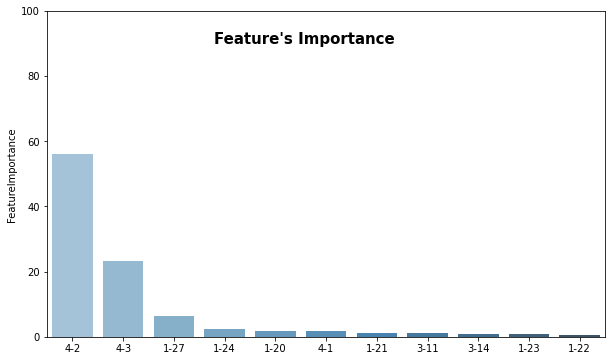

In [7]:
#RF feature's importance graph
fig, ax = plt.subplots(figsize=(10, 6))

g = sns.barplot(x=FeatureImportance_DT.index, y='FeatureImportance',data=FeatureImportance_DT, ax=ax, 
               palette=sns.color_palette("Blues_d", n_colors=13, desat=1))

title = "Feature's Importance"
ax.text(2.8, 90, title, horizontalalignment='left', color='black',fontsize=15,fontweight='bold') 
    
ax.set_ylim(0, 100)

ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.tight_layout;

"""
DT에서 뽑은 feature importance
"""

디시전트리에서는 변수중요도가
4-2,4-3,1-27,1-21,1-24순으로 높다
조건을 걸어 4가지 변수를 시각화하게 되었습니다.

RF

In [8]:
#Random Forest
RF = RandomForestRegressor(random_state=26, min_samples_split=4, max_depth=6)
RF.fit(X_train, y_train)

train_predict = RF.predict(X_train)
rf_run_predict = RF.predict(X_test)
print(f"RF train RMSE : {MSE(train_predict, y_train) ** 0.5}")
print(f"RF test RMSE : {MSE(rf_run_predict, y_test) ** 0.5}")

RF_FI = {'FeatureImportance':RF.feature_importances_}
         
"""
RF도 아무 하이퍼파라미터 설정을 안했더니 overfitting이 일어났습니다. 그래서 min_samples_split
(한 잎당 최소 데이터 4개), max_depth를 하이퍼 파라미터로 설정하였습니다.
성능은 앞서 나온 두 모델과 거의 다름이 없었습니다.
RF도 DT와 마찬가지로 feature importance를 뽑을 수 있습니다.
"""

/home/visonlab01/anaconda3/envs/jeongyoon/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RF train RMSE : 14.868780597800484
RF test RMSE : 15.54310967582693


'\nRF도 아무 하이퍼파라미터 설정을 안했더니 overfitting이 일어났습니다. 그래서 min_samples_split\n(한 잎당 최소 데이터 4개), max_depth를 하이퍼 파라미터로 설정하였습니다.\n성능은 앞서 나온 두 모델과 거의 다름이 없었습니다.\nRF도 DT와 마찬가지로 feature importance를 뽑을 수 있습니다.\n'

In [9]:
#embedded method - feature selection(Random Forest)
FeatureImportance_RF = pd.DataFrame(RF_FI, index=X_columns)
criteria = FeatureImportance_RF['FeatureImportance'] <= 0.025
drop_index = FeatureImportance_RF[criteria].index
FeatureImportance_RF.drop(drop_index, inplace=True)
FeatureImportance_RF *= 100
FeatureImportance_RF.sort_values('FeatureImportance', ascending=False, inplace=True)

per = FeatureImportance_RF.sum()

"""
기여도가 2.5%이하는 drop시키고 중요한 feature들만 남겼습니다.
"""

'\n기여도가 2.5%이하는 drop시키고 중요한 feature들만 남겼습니다.\n'

'\n랜덤 포레스트에서는 변수 중요도가 4-2,4-3,1-27,1-24순으로 높게 나타났습니다.\n조건을 걸어 4가지 변수를 시각화했습니다.\n'

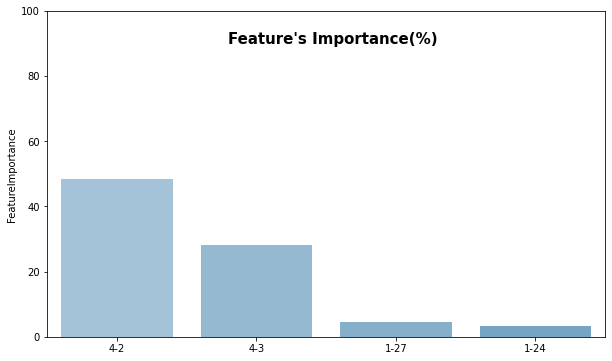

In [10]:
#Filter method feature's importance graph
fig, ax = plt.subplots(figsize=(10, 6))

g = sns.barplot(x=FeatureImportance_RF.index, y='FeatureImportance',data=FeatureImportance_RF, ax=ax, 
               palette=sns.color_palette("Blues_d", n_colors=13, desat=1))

title = "Feature's Importance(%)"
ax.text(0.8, 90, title, horizontalalignment='left', color='black',fontsize=15,fontweight='bold') 
    
ax.set_ylim(0, 100)

ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.tight_layout;

"""
랜덤 포레스트에서는 변수 중요도가 4-2,4-3,1-27,1-24순으로 높게 나타났습니다.
조건을 걸어 4가지 변수를 시각화했습니다.
"""

변수 선택 및 추출

In [11]:
#filter method - feature selection
select = SelectKBest(f_regression, k=20)
select.fit(X_train, y_train)
total = select.scores_.sum()

FS = {'FeatureSelect' : select.scores_ / total}
FeatureSelect = pd.DataFrame(FS, index=X_columns)
criteria = FeatureSelect['FeatureSelect'] <= 0.03
drop_index = FeatureSelect[criteria].index
FeatureSelect.drop(drop_index, inplace=True)
FeatureSelect.sort_values('FeatureSelect', ascending=False, inplace=True)
FeatureSelect *= 100
display(FeatureSelect)

"""
머신러닝 알고리즘에 내장된 feature importance selection이 아닌 filter method로 
feature importance를 뽑아봤습니다. 역시나 기여도가 3%이하인 feature들은 drop시켰습니다.
"""

/home/visonlab01/anaconda3/envs/jeongyoon/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,FeatureSelect
4-2,9.915591
4-3,8.463790
1-24,6.475094
1-27,6.146999
3-14,4.736543
3-11,4.560603
3-12,4.180697
3-9,4.165344
3-13,4.027466
3-15,3.865783


'\n머신러닝 알고리즘에 내장된 feature importance selection이 아닌 filter method로 \nfeature importance를 뽑아봤습니다. 역시나 기여도가 3%이하인 feature들은 drop시켰습니다.\n'

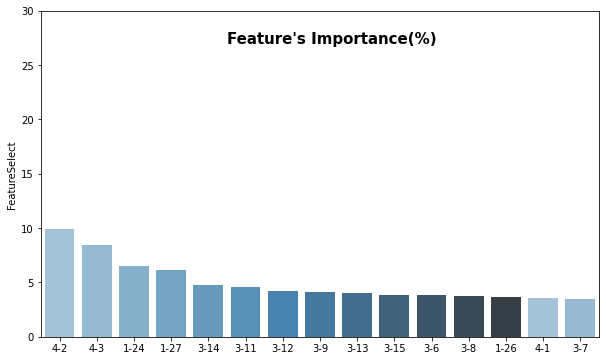

In [12]:
#filter method feature's importance graph
fig, ax = plt.subplots(figsize=(10, 6))

g = sns.barplot(x=FeatureSelect.index, y='FeatureSelect',data=FeatureSelect, ax=ax, 
               palette=sns.color_palette("Blues_d", n_colors=13, desat=1))

title = "Feature's Importance(%)"
ax.text(4.5, 27, title, horizontalalignment='left', color='black',fontsize=15,fontweight='bold') 
    
ax.set_ylim(0, 30)

ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.tight_layout;

리그레션이기 때문에 f_regression을 활용하게 되었습니다. 
20개로 하였고 
필터 메소드에서 20개중 15개를 시각화하게 되었습니다.

In [13]:
#Retrain machine learning models with selected feautures
X_train_selected = select.transform(X_train)
X_test_selected = select.transform(X_test)

LR2 = LinearRegression()
DT2 = DecisionTreeRegressor(random_state=26, max_depth=6)
RF2 = RandomForestRegressor(random_state=26, min_samples_split=4, max_depth=6)

LR2.fit(X_train_selected, y_train)
DT2.fit(X_train_selected, y_train)
RF2.fit(X_train_selected, y_train)

#Linear Regression
y_train_hat_LR2 = LR2.predict(X_train_selected)
y_test_hat_LR2 = LR2.predict(X_test_selected)

#Decision Tree
y_train_hat_DT2 = DT2.predict(X_train_selected)
y_test_hat_DT2 = DT2.predict(X_test_selected)

#Random Forest
y_train_hat_RF2 = RF2.predict(X_train_selected)
y_test_hat_RF2 = RF2.predict(X_test_selected)

print(f"LR2 train RMSE : {MSE(y_train, y_train_hat_LR2) ** 0.5}")
print(f"LR2 test RMSE : {MSE(y_test, y_test_hat_LR2) ** 0.5}", end='\n\n')

print(f"DT2 train RMSE : {MSE(y_train, y_train_hat_DT2) ** 0.5}")
print(f"DT2 test RMSE : {MSE(y_test, y_test_hat_DT2) ** 0.5}", end='\n\n')

print(f"RF2 train RMSE : {MSE(y_train, y_train_hat_RF2) ** 0.5}") 
print(f"RF2 test RMSE : {MSE(y_test, y_test_hat_RF2) ** 0.5}", end='\n\n')

"""
52개의 속성이 너무 많은 것 같아 dimension reduction을 위해 filter method로 feature를 뽑고,
filter method로 뽑힌 중요한 속성(20개)으로 위의 모델들을 다시 학습시켰습니다. 
하지만 눈에 띄는 큰 차이는 없었습니다.
"""

/home/visonlab01/anaconda3/envs/jeongyoon/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


LR2 train RMSE : 16.418295434576386
LR2 test RMSE : 16.565564502524893

DT2 train RMSE : 15.48959148108335
DT2 test RMSE : 16.076052038952252

RF2 train RMSE : 15.219502100679676
RF2 test RMSE : 15.726987168215796



'\n52개의 속성이 너무 많은 것 같아 dimension reduction을 위해 filter method로 feature를 뽑고,\nfilter method로 뽑힌 중요한 속성(20개)으로 위의 모델들을 다시 학습시켰습니다. \n하지만 눈에 띄는 큰 차이는 없었습니다.\n'

In [14]:
#feature extraction - PCA
pca = PCA(n_components=30)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

"""
PCA를 이용해 30개의 feature들을 추출했습니다.
"""

'\nPCA를 이용해 30개의 feature들을 추출했습니다.\n'

In [15]:
#Retrain machine learning models with extracted feautures
LR3 = LinearRegression()
DT3 = DecisionTreeRegressor(random_state=26, max_depth=6)
RF3 = RandomForestRegressor(random_state=26, min_samples_split=4, max_depth=6)

LR3.fit(X_train_pca, y_train)
DT3.fit(X_train_pca, y_train)
RF3.fit(X_train_pca, y_train)

#Linear Regression
y_train_hat_LR3 = LR3.predict(X_train_pca)
y_test_hat_LR3 = LR3.predict(X_test_pca)

#Decision Tree
y_train_hat_DT3 = DT3.predict(X_train_pca)
y_test_hat_DT3 = DT3.predict(X_test_pca)

#Random Forest
y_train_hat_RF3 = RF3.predict(X_train_pca)
y_test_hat_RF3 = RF3.predict(X_test_pca)


print(f"LR3 train RMSE : {MSE(y_train, y_train_hat_LR3) ** 0.5}")
print(f"LR3 test RMSE : {MSE(y_test, y_test_hat_LR3) ** 0.5}", end = '\n\n')

print(f"DT3 train RMSE : {MSE(y_train, y_train_hat_DT3) ** 0.5}")
print(f"DT3 test RMSE : {MSE(y_test, y_test_hat_DT3) ** 0.5}", end = '\n\n')

print(f"RF3 train RMSE : {MSE(y_train, y_train_hat_RF3) ** 0.5}") 
print(f"RF3 test RMSE : {MSE(y_test, y_test_hat_RF3) ** 0.5}", end = '\n\n')

"""
dimension reduction을 위해 PCA로 feature를 추출하였고,
PCA로 생성된 features(30개)으로 위의 모델들을 다시 학습시켰습니다. 
하지만 이것 역시 눈에 띄는 큰 차이는 없었습니다.

LR의 경우 RMSE값이 FIlter와 PCA를 한 뒤 한 것이 처음에 한 LR보다 조금 높게 나왔습니다.
DT의 경우 RMSE값이 FIlter의 경우 처음한 것보다 매우 조금 낮게 나왔고,
PCA를 한뒤에는 처음한 것보다 더 높게 나왔다
DT의 경우 RMSE값이 처음 한것이 가장 낮게 나왔고 Filter와 PCA순으로 높게 나왔다.
"""

/home/visonlab01/anaconda3/envs/jeongyoon/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


LR3 train RMSE : 15.895245006747516
LR3 test RMSE : 16.1886324034849

DT3 train RMSE : 15.67104863818857
DT3 test RMSE : 16.811289151918544

RF3 train RMSE : 14.96762256189319
RF3 test RMSE : 15.94958512629898



'\ndimension reduction을 위해 PCA로 feature를 추출하였고,\nPCA로 생성된 features(30개)으로 위의 모델들을 다시 학습시켰습니다. \n하지만 이것 역시 눈에 띄는 큰 차이는 없었습니다.\n\nLR의 경우 RMSE값이 FIlter와 PCA를 한 뒤 한 것이 처음에 한 LR보다 조금 높게 나왔습니다.\nDT의 경우 RMSE값이 FIlter의 경우 처음한 것보다 매우 조금 낮게 나왔고,\nPCA를 한뒤에는 처음한 것보다 더 높게 나왔다\nDT의 경우 RMSE값이 처음 한것이 가장 낮게 나왔고 Filter와 PCA순으로 높게 나왔다.\n'

In [16]:
##Retrain Deep learning models with extracted feautures
model2 = create_model(30)
history = model2.fit(X_train_pca, y_train, batch_size=128, epochs=30, verbose=False)
pre = model2.predict(X_test_pca)
model2.evaluate(X_test_pca, y_test)
print(f"RMSE : {MSE(pre, y_test) ** 0.5}")

"""
혹시나 싶어 DNN에 PCA로 생성된 feature들을 학습시켜봤습니다. 하지만 역시 성능은 그대로였습니다.
"""

81/81 [==============================] - 0s 700us/step - loss: 269.8931 - mse: 269.8931
RMSE : 16.428421153724855


'\n혹시나 싶어 DNN에 PCA로 생성된 feature들을 학습시켜봤습니다. 하지만 역시 성능은 그대로였습니다.\n'

In [17]:
#DNN bagging model
k = 10 #10times
threshold = 270 #MSE threshold

avg_list = []
mse_list = []
X_trainb = np.array(X_train)
X_testb = np.array(X_test)
y_trainb = np.array(y_train)
y_testb = np.array(y_test)

for fold in range(k):
    idx = np.random.choice(X_trainb.shape[0], X_trainb.shape[0], replace=True)
    X_train_base = X_trainb[idx,:]
    y_train_base = y_trainb[idx]
    
    model = create_model(52)
    history = model.fit(X_train_base, y_train_base, epochs=50, batch_size=256, 
                        verbose=False)
    loss, mse = model.evaluate(X_testb, y_testb)
    mse_list.append(mse)
    
    if mse < threshold:
        pre = model.predict(X_testb)
        avg_list.append(pre)
        
    print(f"last train mse : {history.history['mse'][-1]}")
    print(f"loss : {loss}, mse : {mse}")
    

new_k = len(avg_list)
total_avg = np.zeros(len(y_testb))

for i in range(len(y_testb)):
    for model_pre in range(new_k):
        total_avg[i] += avg_list[model_pre][i]

if new_k > 0:
    total_avg = total_avg / new_k
    print(f"length : {new_k}")
    print(f"bagging nn model rmse : {MSE(y_testb, total_avg) ** 0.5}")

"""
DNN의 성능을 강제로 끌어올리기 위해 bagging을 사용하였습니다. 데이터셋을 10번 복원추출 후, 
그 데이터셋으로 10개의 같은 DNN모델을 학습을 시켰습니다. 학습 완료 후, test mse값이 일정이상
넘지 못한 열등한 모델은 제외하고, threshold값을 넘은 우수한 모델들로만 bagging모델을 구성하였습니다.
우수한 모델이 regression한 값의 평균으로 evaluation 했더니 RMSE값이 낮게 나왔습니다.
"""

81/81 [==============================] - 0s 666us/step - loss: 245.5611 - mse: 245.5611
last train mse : 245.45108032226562
loss : 245.5611114501953, mse : 245.5611114501953
81/81 [==============================] - 0s 675us/step - loss: 247.5284 - mse: 247.5284
last train mse : 255.41229248046875
loss : 247.5283660888672, mse : 247.5283660888672
81/81 [==============================] - 0s 667us/step - loss: 249.6874 - mse: 249.6874
last train mse : 247.51588439941406
loss : 249.6873779296875, mse : 249.6873779296875
81/81 [==============================] - 0s 685us/step - loss: 252.8458 - mse: 252.8458
last train mse : 232.4851531982422
loss : 252.84580993652344, mse : 252.84580993652344
81/81 [==============================] - 0s 670us/step - loss: 288.9222 - mse: 288.9222
last train mse : 251.63487243652344
loss : 288.9222106933594, mse : 288.9222106933594
81/81 [==============================] - 0s 679us/step - loss: 260.0682 - mse: 260.0682
last train mse : 258.6475830078125
loss :

'\nDNN의 성능을 강제로 끌어올리기 위해 bagging을 사용하였습니다. 데이터셋을 10번 복원추출 후, \n그 데이터셋으로 10개의 같은 DNN모델을 학습을 시켰습니다. 학습 완료 후, test mse값이 일정이상\n넘지 못한 열등한 모델은 제외하고, threshold값을 넘은 우수한 모델들로만 bagging모델을 구성하였습니다.\n우수한 모델이 regression한 값의 평균으로 evaluation 했더니 RMSE값이 낮게 나왔습니다.\n'

데이터 시각화

In [18]:
DT_X=X_data[['4-2','4-3','1-27','1-21']]
RF_X=X_data[['4-2','4-3','1-27','1-24']]
Filter_X=X_data[['4-2','4-3','1-27','1-21','3-14','3-11','3-12','3-9','3-13','3-6','3-15','3-8','1-26','3-7','4-1']]
AVG_Y=Y_data[['average score']]
DT_corr=pd.concat([DT_X,AVG_Y],axis=1)
RF_corr=pd.concat([RF_X,AVG_Y],axis=1)
Filter_corr=pd.concat([Filter_X,AVG_Y],axis=1)
Total_Avg=pd.concat([X_data,AVG_Y],axis=1)
"""
DF, RF에서는 변수 중요도 상위 4개를 가지고 오고 Filter에서는 15개를 선정하여 가지고 오게 되었습니다.
Filter에서는 나름 고르게 나왔기에 15개를 선정하여 가지고 오게되었습니다.
Total_Avg는 본래 데이터에서 분석하기위해 만든 Avg점수와 X_data를 합쳐서 만든 것입니다.
각각 데이터프레임을 합치는 작업을 하였습니다.
"""

'\nDF, RF에서는 변수 중요도 상위 4개를 가지고 오고 Filter에서는 15개를 선정하여 가지고 오게 되었습니다.\nFilter에서는 나름 고르게 나왔기에 15개를 선정하여 가지고 오게되었습니다.\nTotal_Avg는 본래 데이터에서 분석하기위해 만든 Avg점수와 X_data를 합쳐서 만든 것입니다.\n각각 데이터프레임을 합치는 작업을 하였습니다.\n'

In [19]:
Corr_DT=DT_corr.corr()
Corr_RF=RF_corr.corr()
Corr_Filter=Filter_corr.corr()
Corr_Total=total_df.corr()
Corr_Total=Corr_Total[52:]
Corr_Total=Corr_Total.drop(labels=['label-1','label-2','label-3','label-4','label-5','label-6'],axis=1)
Corr_Avg=Total_Avg.corr()
Corr_Avg=Corr_Avg[52:]
Corr_Avg=Corr_Avg.drop(labels=['average score'],axis=1)
"""
corr()은 각각 상관계수를 구해주는 것이므로 데이터프레임마다 적용 시켜주었습니다.
DT,RF,Filter는 분석을 거친뒤 나온 변수입니다. 목적과 변수, 변수와 변수 사이의 상관계수를 보기 위하여 그대로 두었습니다.
전체데이터프레임에도 상관계수를 적용시켜보았습니다.
전체데이터에서는 목적으로 하는 것과 변수와의 상관계수만을 보기 위하여 라벨들을 제거 하는 작업을 거쳤습니다.
"""

'\ncorr()은 각각 상관계수를 구해주는 것이므로 데이터프레임마다 적용 시켜주었습니다.\nDT,RF,Filter는 분석을 거친뒤 나온 변수입니다. 목적과 변수, 변수와 변수 사이의 상관계수를 보기 위하여 그대로 두었습니다.\n전체데이터프레임에도 상관계수를 적용시켜보았습니다.\n전체데이터에서는 목적으로 하는 것과 변수와의 상관계수만을 보기 위하여 라벨들을 제거 하는 작업을 거쳤습니다.\n'

'\n전체 데이터셋에서 국영수원점수,척도점수와 변수간의 상관계수를 히트맵으로 시각화 하였습니다.\n색이 연할 수록 상관계수가 높은 것이고 4-1,4-2,4-3측과 1-24,1-27측에서 목적과 상관관계가 상대적으로 높은 것으로 보입니다.\n척도점수에서는 상관계수가 크게 작용하는 것 같지 않았습니다.\n'

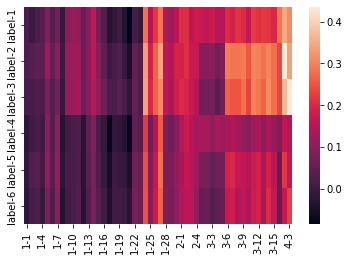

In [20]:
sns.heatmap(Corr_Total)
"""
전체 데이터셋에서 국영수원점수,척도점수와 변수간의 상관계수를 히트맵으로 시각화 하였습니다.
색이 연할 수록 상관계수가 높은 것이고 4-1,4-2,4-3측과 1-24,1-27측에서 목적과 상관관계가 상대적으로 높은 것으로 보입니다.
척도점수에서는 상관계수가 크게 작용하는 것 같지 않았습니다.
"""

'\n전체 데이터셋에서 저희가 사용한 평균점수와 변수간의 상관계수를 히트맵으로 시각화 하였습니다.\n색이 연할 수록 상관계수가 높은 것이고 4-1,4-2,4-3측과 1-24,1-27측에서 상관관계가 상대적으로 높은 것으로 보입니다.\n평균으로 보니 더욱 직관적으로 변하였습니다.\n'

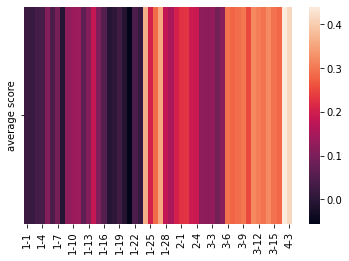

In [21]:
sns.heatmap(Corr_Avg)
"""
전체 데이터셋에서 저희가 사용한 평균점수와 변수간의 상관계수를 히트맵으로 시각화 하였습니다.
색이 연할 수록 상관계수가 높은 것이고 4-1,4-2,4-3측과 1-24,1-27측에서 상관관계가 상대적으로 높은 것으로 보입니다.
평균으로 보니 더욱 직관적으로 변하였습니다.
"""

'\nDT에서 나온 변수와 목적, 변수와 변수 서로의 상관계수를 히트맵으로 시각화 하였습니다.\nDT에서 구한 변수와 평균점수를 상관관계를 보니 4-2가 가장 목적과 상관관계가 있습니다.\n변수간에는 4-2와 4-3간에 상관계수가 높은 것을 볼 수있습니다.\n'

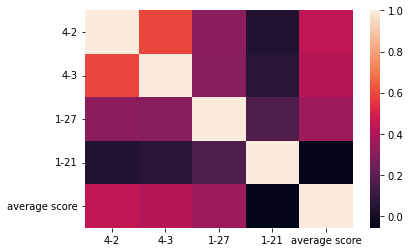

In [22]:
sns.heatmap(Corr_DT)
"""
DT에서 나온 변수와 목적, 변수와 변수 서로의 상관계수를 히트맵으로 시각화 하였습니다.
DT에서 구한 변수와 평균점수를 상관관계를 보니 4-2가 가장 목적과 상관관계가 있습니다.
변수간에는 4-2와 4-3간에 상관계수가 높은 것을 볼 수있습니다.
"""

'\nRF에서 나온 변수와 목적, 변수와 변수 서로의 상관계수를 히트맵으로 시각화 하였습니다.\nRF에서도 구한 변수와 평균점수를 상관관계를 보니 4-2가 상관관계가 있습니다.\n변수간에는 4-2와 4-3간에 상관계수가 높은 것을 볼 수있습니다.\n'

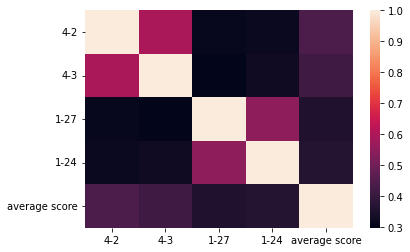

In [23]:
sns.heatmap(Corr_RF)
"""
RF에서 나온 변수와 목적, 변수와 변수 서로의 상관계수를 히트맵으로 시각화 하였습니다.
RF에서도 구한 변수와 평균점수를 상관관계를 보니 4-2가 상관관계가 있습니다.
변수간에는 4-2와 4-3간에 상관계수가 높은 것을 볼 수있습니다.
"""

'\nFilter에서 나온 변수와 목적, 변수와 변수 서로의 상관계수를 히트맵으로 시각화 하였습니다.\nFilter에서 구한 변수와 평균점수를 상관관계를 보니 4-2가 상관관계가 있다.\n변수간에는 앞의 숫자인 3끼리와 4끼리 상관계수가 높은 것으로 나왔습니다.\n'

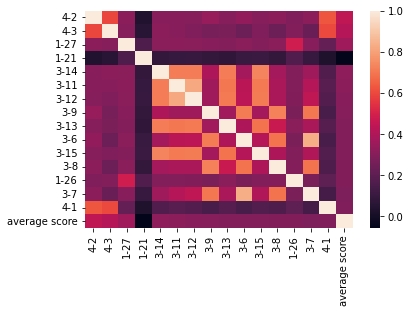

In [24]:
sns.heatmap(Corr_Filter)
"""
Filter에서 나온 변수와 목적, 변수와 변수 서로의 상관계수를 히트맵으로 시각화 하였습니다.
Filter에서 구한 변수와 평균점수를 상관관계를 보니 4-2가 상관관계가 있다.
변수간에는 앞의 숫자인 3끼리와 4끼리 상관계수가 높은 것으로 나왔습니다.
"""